In [1]:
import pandas as pd
import numpy as np
import os
from os import getcwd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(getcwd()+"\\Stocks\\a.us.txt", parse_dates=['Date'], date_parser=dateparser)

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1,1999-11-19,28.986,29.027,26.872,27.257,16142920,0
2,1999-11-22,27.886,29.702,27.044,29.702,6970266,0
3,1999-11-23,28.688,29.446,27.002,27.002,6332082,0
4,1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [4]:
len(df)

4521

# Predict next 4 High,Open,Low given last 20 High,Open,Low

In [5]:
data = df[['High', 'Open', 'Low']]

In [6]:
data.head()

,High,Open,Low
0,33.754,30.713,27.002
1,29.027,28.986,26.872
2,29.702,27.886,27.044
3,29.446,28.688,27.002
4,28.309,27.083,27.002


In [7]:
# change time series data into data subsets for encoder decoder supervised learning
# looking back n_past data points to predict n_future data points
def create_datasets(series, n_past, n_future):
    data = [] # encoder input
    target = [] # target sequence
    data2 = [] # decoder input
    
    for i in range(len(series) - (n_past+n_future-1)):
        
        indicies = range(i,n_past+i)
        target_indicies = range(n_past+i, n_past+i+n_future)
        indicies2 = range(n_past+i, n_past+i+n_future-1)
        
        data.append(series[indicies])
        
        target.append(series[target_indicies])

        tmp = series[indicies2]
        filler = np.zeros((1, 3)) # using 0 as start of sequence
        tmp = np.concatenate((filler, tmp), axis=0) # tmp => target(t-1)
        
        data2.append(tmp)
    
    return np.array(data), np.array(target), np.array(data2)

In [9]:
n_past = 20
n_future = 4
n_feat = 3

data, target, data2 = create_datasets(data.values, n_past, n_future)

In [10]:
data.shape, target.shape, data2.shape

((4498, 20, 3), (4498, 4, 3), (4498, 4, 3))

In [11]:
data[0]

array([[33.754, 30.713, 27.002],
       [29.027, 28.986, 26.872],
       [29.702, 27.886, 27.044],
       [29.446, 28.688, 27.002],
       [28.309, 27.083, 27.002],
       [28.012, 27.594, 27.509],
       [28.65 , 27.676, 27.38 ],
       [28.986, 28.35 , 27.634],
       [29.324, 28.48 , 28.273],
       [30.375, 29.532, 29.155],
       [30.842, 30.336, 29.909],
       [31.348, 30.547, 30.505],
       [31.052, 30.883, 29.909],
       [30.795, 30.547, 30.249],
       [31.012, 30.547, 30.547],
       [31.012, 30.842, 30.209],
       [31.221, 30.713, 29.958],
       [30.635, 30.635, 28.391],
       [28.561, 28.35 , 27.676],
       [31.896, 28.35 , 28.35 ]])

In [12]:
target[0]

array([[31.808, 31.308, 30.674],
       [31.687, 31.221, 31.134],
       [31.517, 31.517, 31.052],
       [32.104, 31.47 , 31.261]])

In [13]:
data2[0]

array([[ 0.   ,  0.   ,  0.   ],
       [31.808, 31.308, 30.674],
       [31.687, 31.221, 31.134],
       [31.517, 31.517, 31.052]])

In [14]:
data = data.reshape((data.shape[0], data.shape[1]*data.shape[2]))
target = target.reshape((target.shape[0], target.shape[1]*target.shape[2]))
data2 = data2.reshape((data2.shape[0], data2.shape[1]*data2.shape[2]))

In [15]:
data.shape, target.shape, data2.shape

((4498, 60), (4498, 12), (4498, 12))

In [16]:
# randomize along axis=0
def randomize_data(data, target, data2, num_feat, n_future_steps):
    
    tmp = np.concatenate((data, target, data2), axis=1)
    
    np.random.seed(101)
    np.random.shuffle(tmp)
    
    tmp_data = tmp[:, :-(2*num_feat*n_future_steps)]
    tmp_target = tmp[:, -(2*num_feat*n_future_steps):-(num_feat*n_future_steps)]
    tmp_data2 = tmp[:, -(num_feat*n_future_steps):]
    
    return tmp_data, tmp_target, tmp_data2

In [18]:
data, target, data2 = randomize_data(data, target, data2, n_feat, n_future)
print(data.shape, target.shape, data2.shape)

(4498, 60) (4498, 12) (4498, 12)


In [19]:
TRAIN_SPLIT = int(data.shape[0] * 0.8)

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()
scaler_data2 = MinMaxScaler()

In [22]:
x_train = data[:TRAIN_SPLIT]
x_val = data[TRAIN_SPLIT:]

y_train = target[:TRAIN_SPLIT]
y_val = target[TRAIN_SPLIT:]

x2_train = data2[:TRAIN_SPLIT]
x2_val = data2[TRAIN_SPLIT:]

In [23]:
x_train = scaler_data.fit_transform(x_train)
x_val = scaler_data.transform(x_val)

In [24]:
y_train = scaler_target.fit_transform(y_train)
y_val = scaler_target.transform(y_val)

In [25]:
x2_train = scaler_data2.fit_transform(x2_train)
x2_val = scaler_data2.transform(x2_val)

In [26]:
x2_train[0]

array([0.        , 0.        , 0.        , 0.15725224, 0.16304451,
       0.17722913, 0.15547522, 0.15753651, 0.17029845, 0.15533778,
       0.16036294, 0.1711604 ])

In [27]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)
print(x2_train.shape, x2_val.shape)

x_train = x_train.reshape((TRAIN_SPLIT, n_past, n_feat))
x_val = x_val.reshape((len(data) - TRAIN_SPLIT, n_past, n_feat))

y_train = y_train.reshape((TRAIN_SPLIT, n_future, n_feat))
y_val = y_val.reshape((len(data) - TRAIN_SPLIT, n_future, n_feat))

x2_train = x2_train.reshape((TRAIN_SPLIT, n_future, n_feat))
x2_val = x2_val.reshape((len(data) - TRAIN_SPLIT, n_future, n_feat))

print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)
print(x2_train.shape, x2_val.shape)

(3598, 60) (900, 60)
(3598, 12) (900, 12)
(3598, 12) (900, 12)
(3598, 20, 3) (900, 20, 3)
(3598, 4, 3) (900, 4, 3)
(3598, 4, 3) (900, 4, 3)


In [28]:
x_train[0]

array([[0.16490506, 0.17122177, 0.18008177],
       [0.16401669, 0.17111629, 0.18957596],
       [0.16315272, 0.16973314, 0.18326483],
       [0.16289746, 0.16647039, 0.18703642],
       [0.17283752, 0.1693151 , 0.18319874],
       [0.17415845, 0.17896059, 0.1894437 ],
       [0.17623083, 0.18531766, 0.18985549],
       [0.16816638, 0.17448451, 0.18705366],
       [0.16666748, 0.17457954, 0.1809208 ],
       [0.1664986 , 0.17206804, 0.18357322],
       [0.15898011, 0.17189707, 0.17452172],
       [0.1457949 , 0.14492264, 0.15243966],
       [0.14865187, 0.14298204, 0.16049032],
       [0.15169538, 0.15672294, 0.16935409],
       [0.15188192, 0.16069941, 0.16728345],
       [0.14963617, 0.15466333, 0.16569743],
       [0.15663793, 0.16092441, 0.168495  ],
       [0.15757623, 0.15994582, 0.1684179 ],
       [0.15244153, 0.15748764, 0.17628339],
       [0.15568026, 0.16036294, 0.1797152 ]])

In [29]:
x2_train[0]

array([[0.        , 0.        , 0.        ],
       [0.15725224, 0.16304451, 0.17722913],
       [0.15547522, 0.15753651, 0.17029845],
       [0.15533778, 0.16036294, 0.1711604 ]])

In [30]:
y_train[0]

array([[0.15725224, 0.16304451, 0.17722913],
       [0.15547522, 0.15753651, 0.17029845],
       [0.15533778, 0.16036294, 0.1711604 ],
       [0.14825916, 0.15608059, 0.16133587]])

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

rnn_units = 50

tf.keras.backend.clear_session()

encoder_inputs = Input(shape=(None, n_feat))
encoder = LSTM(rnn_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, n_feat))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
#####decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_dense = Dense(n_feat)
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='Huber')

# model.summary()

history = model.fit([x_train, x2_train], y_train,
          epochs=500,
          validation_data=([x_val, x2_val], y_val),
          verbose=1)


Epoch 1/500
113/113 [==============================] - 1s 11ms/step - loss: 0.0159 - val_loss: 9.3491e-04
Epoch 2/500
113/113 [==============================] - 1s 7ms/step - loss: 6.4685e-04 - val_loss: 4.3345e-04
Epoch 3/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5348e-04 - val_loss: 3.4760e-04
Epoch 4/500
113/113 [==============================] - 1s 7ms/step - loss: 4.0769e-04 - val_loss: 3.1621e-04
Epoch 5/500
113/113 [==============================] - 1s 8ms/step - loss: 3.8183e-04 - val_loss: 2.8709e-04
Epoch 6/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5907e-04 - val_loss: 2.6610e-04
Epoch 7/500
113/113 [==============================] - 1s 7ms/step - loss: 3.4288e-04 - val_loss: 2.5124e-04
Epoch 8/500
113/113 [==============================] - 1s 7ms/step - loss: 3.2506e-04 - val_loss: 2.3467e-04
Epoch 9/500
113/113 [==============================] - 1s 7ms/step - loss: 3.1551e-04 - val_loss: 2.2216e-04
Epoch 10/500
113/113 [

113/113 [==============================] - 1s 7ms/step - loss: 9.8541e-05 - val_loss: 7.6467e-05
Epoch 76/500
113/113 [==============================] - 1s 7ms/step - loss: 9.7867e-05 - val_loss: 7.5836e-05
Epoch 77/500
113/113 [==============================] - 1s 7ms/step - loss: 9.7784e-05 - val_loss: 7.6096e-05
Epoch 78/500
113/113 [==============================] - 1s 7ms/step - loss: 9.5946e-05 - val_loss: 7.4939e-05
Epoch 79/500
113/113 [==============================] - 1s 7ms/step - loss: 9.6083e-05 - val_loss: 7.7298e-05
Epoch 80/500
113/113 [==============================] - 1s 7ms/step - loss: 9.4848e-05 - val_loss: 7.4255e-05
Epoch 81/500
113/113 [==============================] - 1s 7ms/step - loss: 9.4530e-05 - val_loss: 7.1784e-05
Epoch 82/500
113/113 [==============================] - 1s 7ms/step - loss: 9.3557e-05 - val_loss: 7.5044e-05
Epoch 83/500
113/113 [==============================] - 1s 7ms/step - loss: 9.3057e-05 - val_loss: 7.3888e-05
Epoch 84/500
113/113 [=

113/113 [==============================] - 1s 7ms/step - loss: 5.6101e-05 - val_loss: 4.0364e-05
Epoch 150/500
113/113 [==============================] - 1s 7ms/step - loss: 5.5998e-05 - val_loss: 4.0558e-05
Epoch 151/500
113/113 [==============================] - 1s 7ms/step - loss: 5.4859e-05 - val_loss: 4.1416e-05
Epoch 152/500
113/113 [==============================] - 1s 7ms/step - loss: 5.4689e-05 - val_loss: 3.9456e-05
Epoch 153/500
113/113 [==============================] - 1s 7ms/step - loss: 5.4880e-05 - val_loss: 4.3081e-05
Epoch 154/500
113/113 [==============================] - 1s 7ms/step - loss: 5.4224e-05 - val_loss: 3.9007e-05
Epoch 155/500
113/113 [==============================] - 1s 7ms/step - loss: 5.3553e-05 - val_loss: 4.0269e-05
Epoch 156/500
113/113 [==============================] - 1s 7ms/step - loss: 5.3751e-05 - val_loss: 3.9624e-05
Epoch 157/500
113/113 [==============================] - 1s 7ms/step - loss: 5.3091e-05 - val_loss: 4.1057e-05
Epoch 158/500
1

Epoch 223/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5341e-05 - val_loss: 3.4013e-05
Epoch 224/500
113/113 [==============================] - 1s 7ms/step - loss: 4.4924e-05 - val_loss: 3.4607e-05
Epoch 225/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5304e-05 - val_loss: 3.4499e-05
Epoch 226/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5568e-05 - val_loss: 3.8396e-05
Epoch 227/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5122e-05 - val_loss: 3.4458e-05
Epoch 228/500
113/113 [==============================] - 1s 7ms/step - loss: 4.4955e-05 - val_loss: 3.3598e-05
Epoch 229/500
113/113 [==============================] - 1s 7ms/step - loss: 4.4506e-05 - val_loss: 3.4325e-05
Epoch 230/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5189e-05 - val_loss: 3.4589e-05
Epoch 231/500
113/113 [==============================] - 1s 7ms/step - loss: 4.5299e-05 - val_loss: 3.3872e-05
E

Epoch 297/500
113/113 [==============================] - 1s 7ms/step - loss: 4.1412e-05 - val_loss: 3.2226e-05
Epoch 298/500
113/113 [==============================] - 1s 7ms/step - loss: 4.1382e-05 - val_loss: 3.5546e-05
Epoch 299/500
113/113 [==============================] - 1s 7ms/step - loss: 4.1021e-05 - val_loss: 3.2758e-05
Epoch 300/500
113/113 [==============================] - 1s 7ms/step - loss: 4.1246e-05 - val_loss: 3.4880e-05
Epoch 301/500
113/113 [==============================] - 1s 7ms/step - loss: 4.1000e-05 - val_loss: 3.4143e-05
Epoch 302/500
113/113 [==============================] - 1s 7ms/step - loss: 4.0847e-05 - val_loss: 3.3125e-05
Epoch 303/500
113/113 [==============================] - 1s 7ms/step - loss: 4.0736e-05 - val_loss: 3.1428e-05
Epoch 304/500
113/113 [==============================] - 1s 7ms/step - loss: 4.0996e-05 - val_loss: 3.2156e-05
Epoch 305/500
113/113 [==============================] - 1s 7ms/step - loss: 4.0313e-05 - val_loss: 3.2101e-05
E

Epoch 371/500
113/113 [==============================] - 1s 7ms/step - loss: 3.7678e-05 - val_loss: 3.1102e-05
Epoch 372/500
113/113 [==============================] - 1s 7ms/step - loss: 3.8274e-05 - val_loss: 3.0320e-05
Epoch 373/500
113/113 [==============================] - 1s 7ms/step - loss: 3.7659e-05 - val_loss: 3.2358e-05
Epoch 374/500
113/113 [==============================] - 1s 7ms/step - loss: 3.8325e-05 - val_loss: 3.1310e-05
Epoch 375/500
113/113 [==============================] - 1s 7ms/step - loss: 3.7586e-05 - val_loss: 3.2397e-05
Epoch 376/500
113/113 [==============================] - 1s 7ms/step - loss: 3.7562e-05 - val_loss: 3.0442e-05
Epoch 377/500
113/113 [==============================] - 1s 7ms/step - loss: 3.8037e-05 - val_loss: 3.0502e-05
Epoch 378/500
113/113 [==============================] - 1s 7ms/step - loss: 3.8201e-05 - val_loss: 3.2037e-05
Epoch 379/500
113/113 [==============================] - 1s 7ms/step - loss: 3.7863e-05 - val_loss: 3.0502e-05
E

Epoch 445/500
113/113 [==============================] - 1s 7ms/step - loss: 3.6090e-05 - val_loss: 3.0806e-05
Epoch 446/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5401e-05 - val_loss: 3.0125e-05
Epoch 447/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5506e-05 - val_loss: 3.0710e-05
Epoch 448/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5153e-05 - val_loss: 2.9857e-05
Epoch 449/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5194e-05 - val_loss: 3.0114e-05
Epoch 450/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5277e-05 - val_loss: 2.9345e-05
Epoch 451/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5381e-05 - val_loss: 3.1117e-05
Epoch 452/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5555e-05 - val_loss: 2.8922e-05
Epoch 453/500
113/113 [==============================] - 1s 7ms/step - loss: 3.5012e-05 - val_loss: 3.0185e-05
E

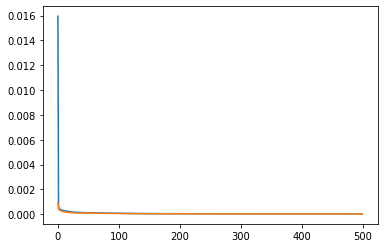

In [36]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

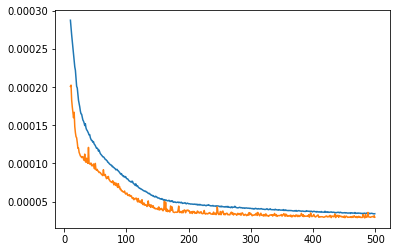

In [37]:
plt.plot(epochs[10:], history.history['loss'][10:])
plt.plot(epochs[10:], history.history['val_loss'][10:])

In [38]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(rnn_units,))
decoder_state_input_c = Input(shape=(rnn_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [39]:
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    
    # encode
    state = infenc.predict(source)
    
    # start of sequence input
    target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    
    # collect predictions
    output = list()
    
    for t in range(n_steps):
        
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        
        # store prediction
        output.append(yhat[0,0,:])
        
        # update state
        state = [h, c]
        
        # update target sequence
        target_seq = yhat
    return np.array(output)

In [40]:
print(x_val[0].shape), x_val[0]

(20, 3)


(None,
 array([[0.10138843, 0.1019394 , 0.1113872 ],
        [0.09834561, 0.10731035, 0.11167368],
        [0.09549845, 0.1016641 , 0.10779662],
        [0.09800199, 0.10096057, 0.11313792],
        [0.10102649, 0.10432528, 0.11383231],
        [0.10642563, 0.10742489, 0.11645366],
        [0.11024793, 0.11120735, 0.12090397],
        [0.11359367, 0.11825313, 0.12824969],
        [0.11299372, 0.11904605, 0.12612139],
        [0.11478476, 0.11915038, 0.12750074],
        [0.11661239, 0.12388386, 0.13767542],
        [0.11724482, 0.12161507, 0.12943506],
        [0.11663612, 0.12230959, 0.1324089 ],
        [0.12094612, 0.12409548, 0.13472595],
        [0.11815787, 0.12567587, 0.13301877],
        [0.11808045, 0.12312685, 0.13121247],
        [0.12049016, 0.12424823, 0.12697206],
        [0.11074545, 0.1199487 , 0.12624514],
        [0.11330789, 0.11692764, 0.13118929],
        [0.11235008, 0.11769234, 0.13280224]]))

In [41]:
test_data = x_train[0].reshape((1,20,3))

In [42]:
predict_sequence(encoder_model, decoder_model, test_data, 4, 3)

array([[0.1571975 , 0.16273393, 0.17313956],
       [0.15900677, 0.16268696, 0.1740604 ],
       [0.16031966, 0.16491485, 0.17612901],
       [0.16040659, 0.16560136, 0.17710032]], dtype=float32)

In [43]:
y_train[0]

array([[0.15725224, 0.16304451, 0.17722913],
       [0.15547522, 0.15753651, 0.17029845],
       [0.15533778, 0.16036294, 0.1711604 ],
       [0.14825916, 0.15608059, 0.16133587]])